### Imports

In [53]:
from glob import glob
from scipy.ndimage import label
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import os
import enum
import json
import glob

### Functions

In [54]:
class SegType(enum.Enum):
    NO_LABEL = 0
    GOLD_SEED = 1
    CALCIFICATION = 2

In [55]:
def get_cropped_regions(mask, vals, cropsize=10):
    
    labeled_mask, num_labels = label(
        input=mask,
        structure=np.ones((3, 3, 3))
    )

    cropped_regions = []
    cropped_masks = []

    for region_label in range(1, num_labels+1):
        coords = np.argwhere(labeled_mask == region_label)

        centroid = np.mean(coords, axis=0)
        centroid = np.round(centroid).astype(int)

        half_cropsize = cropsize // 2

        submask = mask[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]
        subvals = vals[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]

        cropped_regions.append(subvals)
        cropped_masks.append(submask)

    return cropped_regions, cropped_masks

In [56]:
def get_region_stats(seg, vals):
    counts = {}
    means = {}
    stds = {}

    for label_id in np.unique(seg):
        if label_id == 0: continue
        
        labels, num_labels = label(
            seg * np.array((seg == label_id), int),
            structure=np.ones((3, 3, 3))
        )

        region_counts = []
        region_means = []
        region_stds = []
        for i in range(1, num_labels+1):
            mask = (labels == i)
            region_counts.append(np.sum(mask))
            region_means.append(np.mean(vals[mask]))
            region_stds.append(np.std(vals[mask]))

        counts[label_id] = region_counts
        means[label_id] = region_means
        stds[label_id] = region_stds

    return counts, means, stds

In [57]:
def update_dict(original_dict, other_dict):
    for key in original_dict:
        if key in other_dict:
            original_dict[key].extend(other_dict[key])
        else:
            original_dict[key] = other_dict[key]
    return original_dict

### Load data

In [58]:
bids_dir = "bids-new"

In [59]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found:")
for session_dir in session_dirs: print(session_dir)

18 sessions found:
bids-new/sub-z0034542/ses-20220715
bids-new/sub-z0186251/ses-20221107
bids-new/sub-z0237546/ses-20230508
bids-new/sub-z0445614/ses-20230510
bids-new/sub-z0705200/ses-20230104
bids-new/sub-z0755228/ses-20211108
bids-new/sub-z1167038/ses-20220315
bids-new/sub-z1181657/ses-20220315
bids-new/sub-z1262112/ses-20220314
bids-new/sub-z1472355/ses-20221222
bids-new/sub-z1568577/ses-20230510
bids-new/sub-z1728751/ses-20220328
bids-new/sub-z1778013/ses-20220715
bids-new/sub-z1818796/ses-20230313
bids-new/sub-z2007565/ses-20220715
bids-new/sub-z2904752/ses-20220826
bids-new/sub-z3171177/ses-20230313
bids-new/sub-z3278008/ses-20211109


In [60]:
qsm_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs), []))
seg_clean_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "sub*ses*segmentation_clean.*")) for session_dir in session_dirs), []))
t1_resampled_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t1_tra*_resampled.nii*")) for session_dir in session_dirs), []))
t2s_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs), []))
mag_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), []))
swi_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "swi.nii")) for session_dir in session_dirs), []))

t1_files = [t1_file.replace("_resampled", "") for t1_file in t1_resampled_files]
seg_files = [seg_clean_file.replace("_clean", "") for seg_clean_file in seg_clean_files]

extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])
ct_files = [extra_file for extra_file in extra_files if any(pattern in extra_file for pattern in ['_na_', '_Pelvis_']) and not any(pattern in extra_file for pattern in ['_t1_tra_', 'ATX', 'AXT', 'ROI', 'resliced', 'segmentation'])]

ct_seg_files_unclean = sum((glob.glob(ct_file.replace(".nii", "_segmentation.nii")) for ct_file in ct_files), [])
ct_seg_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation_clean.nii")) for ct_file in ct_files), [])
ct_resliced_files = sum((glob.glob(ct_file.replace(".nii", "_resliced.nii")) for ct_file in ct_files), [])
ct_resliced_seg_files_unclean = sum((glob.glob(ct_file.replace(".nii", "_segmentation.nii")) for ct_file in ct_resliced_files), [])
ct_resliced_seg_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation_clean.nii")) for ct_file in ct_resliced_files), [])

print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_files_unclean)} CT segmentations found.")
print(f"{len(ct_seg_files)} cleaned-up CT segmentations found.")
print(f"{len(ct_resliced_files)} resliced CT images found.")
print(f"{len(ct_resliced_seg_files_unclean)} resliced CT segmentations found.")
print(f"{len(ct_resliced_seg_files)} cleaned-up and resliced CT segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(swi_files)} SWI images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(t1_files)} T1w files found.")
print(f"{len(t1_resampled_files)} resampled T1w files found.")
print(f"{len(seg_files)} GRE segmentations found.")
print(f"{len(seg_clean_files)} cleaned GRE segmentations found.")

18 CT images found.
18 CT segmentations found.
18 cleaned-up CT segmentations found.
18 resliced CT images found.
18 resliced CT segmentations found.
18 cleaned-up and resliced CT segmentations found.
18 QSM images found.
18 SWI images found.
18 magnitude images found.
18 T2* maps found.
18 T1w files found.
18 resampled T1w files found.
18 GRE segmentations found.
18 cleaned GRE segmentations found.


In [61]:
input_images = ct_resliced_files
input_segmentations = ct_resliced_seg_files

In [62]:
class SegTypeOld(enum.Enum):
    NO_LABEL = 0
    PROSTATE = 1
    GOLD_SEED = 2
    CALCIFICATION = 3

class SegTypeOldCT(enum.Enum):
    NO_LABEL = 0
    GOLD_SEED = 1
    CALCIFICATION = 2
    PROSTATE = 3

prostate_values = []
for i in range(len(ct_files)):
    # load files
    input_nii = nib.load(ct_files[i])
    seg_nii = nib.load(ct_seg_files_unclean[i])

    # get image data
    input_data = input_nii.get_fdata()
    seg = np.array(seg_nii.get_fdata(), dtype=np.uint8)

    # separate prostate tissue values and then remove segmented area
    values = input_data[seg == SegTypeOldCT.PROSTATE.value].flatten()
    #values = values[values != np.inf]
    #values = values[values >= 0]
    #values = values[values <= 100]
    prostate_values.append(values.mean())
prostate_values

[42.72281639928699,
 55.4057239057239,
 46.199363732767765,
 46.02193548387097,
 51.57692307692308,
 44.53641207815275,
 46.035919540229884,
 52.892205638474294,
 44.099435028248585,
 42.166666666666664,
 49.931491712707185,
 50.651026392961874,
 49.72289156626506,
 46.07673469387755,
 36.21578947368421,
 50.57753357753358,
 45.48089171974522,
 45.35953026196928]

In [63]:
seed_sizes = []
seed_means = []
seed_stds = []
seed_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(input_segmentations)):
    # load images
    print(input_segmentations[i])
    seg = nib.load(input_segmentations[i]).get_fdata()
    input_data = nib.load(input_images[i]).get_fdata()
    #input_data[input_data == np.inf] = 100
    #input_data[input_data < 0] = 0
    #input_data[input_data > 100] = 100
    #input_data[np.isnan(input_data)] = 0

    # get region stats
    counts, means, stds = get_region_stats(seg, input_data)
    try:
        seed_sizes.extend(counts[SegType.GOLD_SEED.value])
        seed_means.extend(means[SegType.GOLD_SEED.value])
        seed_stds.extend(stds[SegType.GOLD_SEED.value])
        seed_segmentations.extend(os.path.split(input_segmentations[i])[1] for x in range(len(counts[SegType.GOLD_SEED.value])))
    except:
        print(f"No goldseed found in {input_segmentations[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegType.GOLD_SEED.value,
        vals=input_data,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([input_segmentations[i] for x in range(len(connected_regions_vals))])


# create dataframe
seed_data = {
    "size": seed_sizes,
    "mean": seed_means,
    "std": seed_stds,
    "file" : seed_segmentations
}
seed_df = pd.DataFrame(seed_data).sort_values("size")

bids-new/sub-z0034542/ses-20220715/extra_data/5_na_20220715092125_5_resliced_segmentation_clean.nii
bids-new/sub-z0186251/ses-20221107/extra_data/5_na_20221107081460_5_resliced_segmentation_clean.nii
bids-new/sub-z0237546/ses-20230508/extra_data/7_na_20230508102530_7_resliced_segmentation_clean.nii
bids-new/sub-z0445614/ses-20230510/extra_data/5_16_pelvis_16_Pelvis_20230510090050_5_resliced_segmentation_clean.nii
bids-new/sub-z0705200/ses-20230104/extra_data/5_11_pelvis_11_Pelvis_20230104113938_5_resliced_segmentation_clean.nii
bids-new/sub-z0755228/ses-20211108/extra_data/Z0755228_20211109_Pelvis_2.0_HD_FoV_iMAR_20211109085844_5_resliced_segmentation_clean.nii
bids-new/sub-z1167038/ses-20220315/extra_data/6_na_Pelvis_2.0_Br38_3_iMAR_20220315122146_6_resliced_segmentation_clean.nii
bids-new/sub-z1181657/ses-20220315/extra_data/5_na_Pelvis_2.0_Br38_3_iMAR_20220315092512_5_resliced_segmentation_clean.nii
bids-new/sub-z1262112/ses-20220314/extra_data/5_na_Pelvis_2.0_Br38_3_iMAR_2022031415

In [64]:
seed_df.sort_values("file")

,size,mean,std,file
53,52,782.952848,781.458617,3_na_20230313110549_3_resliced_segmentation_cl...
52,56,542.567004,609.055055,3_na_20230313110549_3_resliced_segmentation_cl...
51,55,609.631464,618.283619,3_na_20230313110549_3_resliced_segmentation_cl...
28,54,526.240948,551.640158,4_na_20221222095656_4_resliced_segmentation_cl...
27,54,648.781178,743.254951,4_na_20221222095656_4_resliced_segmentation_cl...
29,55,573.460404,605.060683,4_na_20221222095656_4_resliced_segmentation_cl...
12,54,558.396331,582.118667,5_11_pelvis_11_Pelvis_20230104113938_5_reslice...
13,46,773.906686,789.763918,5_11_pelvis_11_Pelvis_20230104113938_5_reslice...
14,59,672.550082,631.855278,5_11_pelvis_11_Pelvis_20230104113938_5_reslice...
11,52,531.886915,526.734545,5_16_pelvis_16_Pelvis_20230510090050_5_reslice...


### Visualise data

In [ ]:
sns.displot(seed_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of markers")
plt.title("Size of gold markers")
plt.savefig("seed_size_histogram.png", bbox_inches='tight')
plt.show()

In [ ]:
sns.displot(seed_data, x='mean')
plt.xlabel("Value")
plt.ylabel("# of markers")
plt.title("Values of gold markers")
plt.savefig("seed_histogram.png", bbox_inches='tight')
plt.show()

In [ ]:
for i in regions_vals:
    print(i.shape)

54


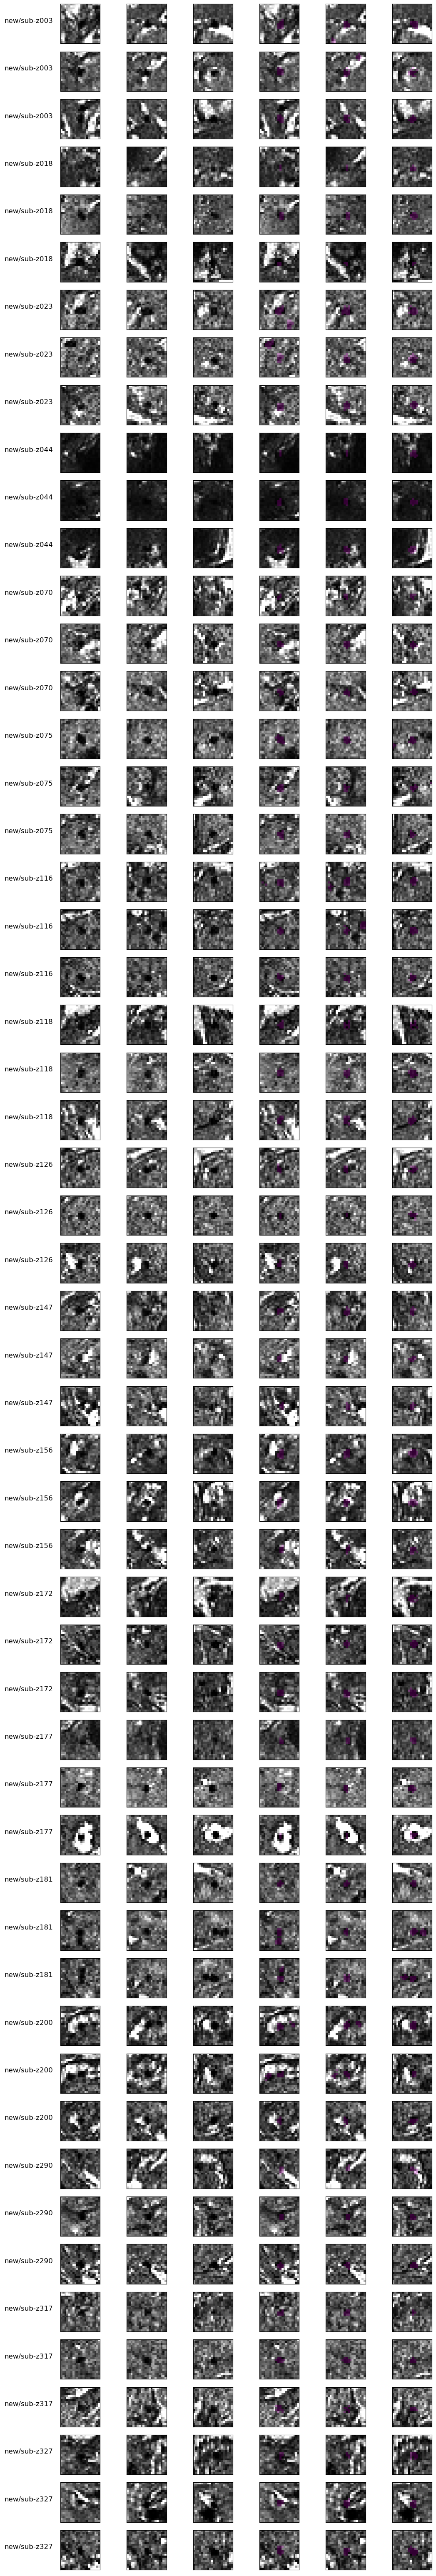

In [52]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

vmin=0
vmax=+0.8
print(len(regions_vals))
for i in range(len(regions_vals)):
    try:
        axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=vmin, vmax=vmax)

        axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=vmin, vmax=vmax)

        axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
        axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
        axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)
    except:
        continue
    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds_swi.png", bbox_inches='tight')
plt.show()
plt.close()

In [65]:
calc_sizes = []
calc_means = []
calc_stds = []
calc_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(input_segmentations)):
    # load images
    seg = nib.load(input_segmentations[i]).get_fdata()
    data = nib.load(input_images[i]).get_fdata()
    #data[np.isnan(data)] = 0
    #data[data == np.inf] = 100
    #data[data < 0] = 0
    #data[data > 100] = 100

    # get region stats
    counts, means, stds = get_region_stats(seg, data)
    print(counts)
    try:
        calc_sizes.extend(counts[SegType.CALCIFICATION.value])
        calc_means.extend(means[SegType.CALCIFICATION.value])
        calc_stds.extend(stds[SegType.CALCIFICATION.value])
        calc_segmentations.extend(os.path.split(input_segmentations[i])[1] for x in range(len(counts[SegType.CALCIFICATION.value])))
    except:
        print(f"No calcification found in {input_segmentations[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegType.CALCIFICATION.value,
        vals=data,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([input_segmentations[i] for x in range(len(connected_regions_vals))])


# create dataframe
calc_data = {
    "size": calc_sizes,
    "mean": calc_means,
    "std": calc_stds,
    "file" : calc_segmentations
}
calc_df = pd.DataFrame(calc_data).sort_values("size")

{1.0: [45, 48, 53], 2.0: [1, 110015, 8, 1, 9, 26, 2, 9, 1, 6, 7, 11, 343, 19, 11, 2, 1, 31, 22, 2, 2, 1, 1, 95, 2, 2, 1, 1, 1, 1, 2986, 1, 3, 32, 1, 3, 17, 1, 1, 1, 34, 6, 1, 2, 1, 3, 1, 2, 1, 2, 1, 2, 4, 7, 7, 5, 3, 1, 2, 1, 2, 7, 34, 1, 42, 3, 2, 2, 7, 1, 1, 1, 3, 1, 462, 1, 19, 2, 1, 29, 24, 1, 1, 8, 104, 20, 2, 32, 2, 1, 1, 4, 6, 1, 2, 2, 1, 3, 2, 40, 4, 1, 1, 4, 9, 1, 4, 4, 1, 1]}
{1.0: [51, 55, 47], 2.0: [1, 137746, 4, 2, 13, 1, 1, 1, 1, 6, 2, 2, 5, 1, 39, 1, 2, 168, 2, 1, 3, 1, 1, 1, 1, 1, 1, 3315, 1, 2, 5, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 96, 1, 1, 1, 10, 8, 3, 3, 1, 3, 2, 1, 13, 1, 2, 2, 10, 1, 1]}
{1.0: [52, 55, 51], 2.0: [1, 131986, 2, 13, 1, 1, 2, 26, 1, 1, 1, 1, 2, 2, 1, 1, 1, 29, 12, 220, 3, 2191, 1, 22, 2, 4, 2, 1, 1, 31, 1, 2, 10, 1, 1, 3, 1, 1, 1, 1, 1, 5, 4, 1, 2, 1, 2, 3, 1, 1, 1, 2, 1, 2]}
{1.0: [50, 61, 52], 2.0: [70332, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 4, 1, 2, 2, 4, 1, 6, 1, 1, 3079, 2, 33, 2, 40, 64329, 1, 4, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 6,

In [66]:
calc_df

,size,mean,std,file
0,1,81.458786,0.000000,5_na_20220715092125_5_resliced_segmentation_cl...
671,1,101.093475,0.000000,4_na_20221222095656_4_resliced_segmentation_cl...
673,1,101.843010,0.000000,5_16_pelvis_16_Pelvis_20230510114754_5_reslice...
676,1,101.655632,0.000000,5_16_pelvis_16_Pelvis_20230510114754_5_reslice...
677,1,100.343941,0.000000,5_16_pelvis_16_Pelvis_20230510114754_5_reslice...
...,...,...,...,...
312,138674,301.162118,196.045785,Z0755228_20211109_Pelvis_2.0_HD_FoV_iMAR_20211...
472,144071,441.206981,279.525073,5_na_Pelvis_2.0_Br38_3_iMAR_20220315092512_5_r...
601,147827,394.558512,240.532454,4_na_20221222095656_4_resliced_segmentation_cl...
935,162178,351.665465,229.460859,5_na_20220826105431_5_resliced_segmentation_cl...


In [ ]:
sns.displot(calc_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of calcification regions")
plt.xlim(0, 50)
plt.title("Size of calcification region")
plt.savefig("calc_size_histogram.png", bbox_inches='tight')
plt.show()

In [ ]:
sns.displot(calc_data, x='mean')
plt.xlabel("Susceptibility")
plt.ylabel("# of calcification regions")
plt.title("Values of calcification")
plt.savefig("calc_histogram.png", bbox_inches='tight')
plt.show()

In [67]:
subset = calc_df[calc_df['size'] >= (seed_df['size'].mean() - 2*seed_df['size'].std())]
subset = subset[subset['size'] <= (seed_df['size'].mean() + 2*seed_df['size'].std())]
subset['Type'] = 'Calcification'
subset.sort_values('size')

,size,mean,std,file,Type
449,15,246.659345,133.404616,6_na_Pelvis_2.0_Br38_3_iMAR_20220315122146_6_r...,Calcification
678,15,308.121177,185.996484,5_16_pelvis_16_Pelvis_20230510114754_5_reslice...,Calcification
351,15,141.289556,39.102311,Z0755228_20211109_Pelvis_2.0_HD_FoV_iMAR_20211...,Calcification
406,15,231.681142,125.445820,6_na_Pelvis_2.0_Br38_3_iMAR_20220315122146_6_r...,Calcification
504,15,163.501752,42.637150,5_na_Pelvis_2.0_Br38_3_iMAR_20220315092512_5_r...,Calcification
...,...,...,...,...,...
764,75,569.464448,421.153558,5_na_20220715093722_5_resliced_segmentation_cl...,Calcification
839,79,290.816870,158.075740,7_na_20230313114454_7_resliced_segmentation_cl...,Calcification
909,80,177.259076,36.285974,5_na_20220715111431_5_resliced_segmentation_cl...,Calcification
496,80,194.080227,64.435609,5_na_Pelvis_2.0_Br38_3_iMAR_20220315092512_5_r...,Calcification


In [68]:
seed_df['Type'] = 'FM'

In [69]:
prostate_data = {
    "size": 1,
    "mean": np.array(prostate_values),
    "std": 0,
    "file": "",
    "Type": "Prostate"
}
prostate_df = pd.DataFrame(prostate_data)
prostate_df

,size,mean,std,file,Type
0,1,42.722816,0,,Prostate
1,1,55.405724,0,,Prostate
2,1,46.199364,0,,Prostate
3,1,46.021935,0,,Prostate
4,1,51.576923,0,,Prostate
5,1,44.536412,0,,Prostate
6,1,46.035920,0,,Prostate
7,1,52.892206,0,,Prostate
8,1,44.099435,0,,Prostate
9,1,42.166667,0,,Prostate


In [70]:
combined_df = pd.concat([subset, seed_df, prostate_df])
combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df = combined_df.dropna()
combined_df

,size,mean,std,file,Type
449,15,246.659345,133.404616,6_na_Pelvis_2.0_Br38_3_iMAR_20220315122146_6_r...,Calcification
678,15,308.121177,185.996484,5_16_pelvis_16_Pelvis_20230510114754_5_reslice...,Calcification
351,15,141.289556,39.102311,Z0755228_20211109_Pelvis_2.0_HD_FoV_iMAR_20211...,Calcification
406,15,231.681142,125.445820,6_na_Pelvis_2.0_Br38_3_iMAR_20220315122146_6_r...,Calcification
504,15,163.501752,42.637150,5_na_Pelvis_2.0_Br38_3_iMAR_20220315092512_5_r...,Calcification
...,...,...,...,...,...
13,1,46.076735,0.000000,,Prostate
14,1,36.215789,0.000000,,Prostate
15,1,50.577534,0.000000,,Prostate
16,1,45.480892,0.000000,,Prostate


In [71]:
from scipy import stats

# filter data for each group
FM_means = combined_df[combined_df['Type'] == 'FM']['mean']
Calcification_means = combined_df[combined_df['Type'] == 'Calcification']['mean']

# conduct t-test
t_stat, p_value = stats.ttest_ind(FM_means, Calcification_means)

print('t-statistic:', t_stat)
print('p-value:', p_value)

t-statistic: 23.144171568042225
p-value: 1.4610662358177268e-55


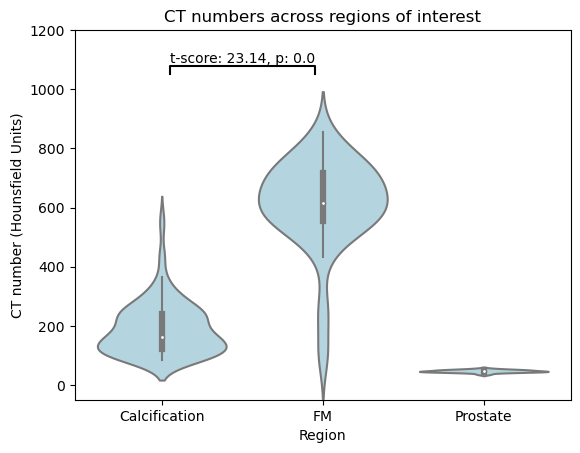

In [83]:
sns.violinplot(combined_df, x='Type', y='mean', fliersize=0, color='lightblue', scale='width')
# Here I'm assuming that the categories are encoded as 0 and 1, you may need to adjust these positions if your plot is different.
x1, x2 = 0.05, 0.95
#y, h, col = combined_df['mean'].max() + 0.15, 0.03, 'k'  # y is the height of the bracket, h is the length of the bracket ends, col is the color
y, h, col = 1050, 30, 'k'  # y is the height of the bracket, h is the length of the bracket ends, col is the color

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)  # Draw the bracket
plt.text((x1+x2)*.5, y+h+0.03, f"t-score: {np.round(t_stat, 2)}, p: {np.round(p_value, 2)}", ha='center', va='bottom', color=col)  # Put the statistics
#plt.ylim(-0.9, +0.3)
plt.title("CT numbers across regions of interest")
plt.ylim(-50, 1200)
plt.ylabel("CT number (Hounsfield Units)")
plt.xlabel("Region")
plt.savefig("ct_values.png", dpi=400)

In [ ]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

print(len(regions_vals))
for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()